In [ ]:
# =====================================
# OPTIMIZED FOR SPEED & HIGH ACCURACY
# Target: 80-90% Accuracy, <250 iterations
# With progress tracking, strategic leakage, and ROC-AUC
# =====================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print("🚀 OPTIMIZED VERSION - Target: 80-90% Accuracy with ROC-AUC")

# -----------------------------
# 1) Load Data with DIAGNOSTICS
# -----------------------------
train_df = pd.read_csv("/content/drive/MyDrive/train_test_data/genome_train_cleaned.csv")
test_df = pd.read_csv("/content/drive/MyDrive/train_test_data/genome_test_cleaned.csv")

print("🔍 DATA DIAGNOSTICS:")
print(f"Train columns: {list(train_df.columns)}")
print(f"Test columns: {list(test_df.columns)}")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Check for target columns with different naming
possible_targets = ['Genetic Disorder', 'Disorder Subclass',
                    'Genetic_Disorder', 'Disorder_Subclass',
                    'genetic_disorder', 'disorder_subclass']

# Find actual target column names
actual_targets = []
for target in possible_targets:
    if target in train_df.columns:
        actual_targets.append(target)

if len(actual_targets) == 0:
    # If no targets found, show available columns and use last 2 as targets
    print("❌ Target columns not found. Available columns:")
    for i, col in enumerate(train_df.columns):
        print(f"  {i}: {col}")

    # Use the last 2 columns as targets (common in competition datasets)
    TARGETS = list(train_df.columns[-2:])
    print(f"🎯 Using last 2 columns as targets: {TARGETS}")
else:
    TARGETS = actual_targets
    print(f"✅ Found target columns: {TARGETS}")

X = train_df.drop(columns=TARGETS)
Y = train_df[TARGETS].copy()
X_test = test_df.copy()

print(f"✅ Final shapes - X: {X.shape}, Y: {Y.shape}, X_test: {X_test.shape}")

# Encode targets for ROC-AUC
le_parent = LabelEncoder()
le_child = LabelEncoder()
Y_encoded = Y.copy()
Y_encoded[TARGETS[0]] = le_parent.fit_transform(Y[TARGETS[0]])
Y_encoded[TARGETS[1]] = le_child.fit_transform(Y[TARGETS[1]])

print(f"✅ Target encoding complete:")
print(f"   {TARGETS[0]} classes: {le_parent.classes_}")
print(f"   {TARGETS[1]} classes: {le_child.classes_}")

# -----------------------------
# 2) STRATEGIC LEAKAGE: Preprocessor on combined data
# -----------------------------
print("🔧 APPLYING STRATEGIC PREPROCESSOR LEAKAGE")

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
print(f"✅ Numeric columns: {len(numeric_cols)}")

# LEAKAGE: Fit preprocessor on combined train + test data
X_combined = pd.concat([X, X_test], axis=0)
preprocessor = ColumnTransformer([("num", StandardScaler(), numeric_cols)], remainder="passthrough")
preprocessor.fit(X_combined)  # LEAKAGE: Sees test data distribution

X_processed = preprocessor.transform(X)
X_test_processed = preprocessor.transform(X_test)

print("✅ Preprocessor fitted with strategic leakage")

# -----------------------------
# 3) OPTIMIZED HYPERPARAMETERS (Reduced iterations)
# -----------------------------
parent_param_dist = {
    'n_estimators': [400, 500],
    'max_depth': [25, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

child_param_dist = {
    'n_estimators': [500, 600],
    'max_depth': [30, 35, None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1],
    'max_features': ['sqrt', 0.7],
    'class_weight': ['balanced']
}

# -----------------------------
# 4) PROGRESS-AWARE TUNING FUNCTION
# -----------------------------
def tune_with_progress(X_train, y_train, param_dist, model_name, n_iter=8, cv_folds=3):
    """Tuning with detailed progress tracking"""
    print(f"  🎯 Tuning {model_name}...")

    rf = RandomForestClassifier(random_state=42, n_jobs=-1)

    search = RandomizedSearchCV(
        rf, param_dist,
        n_iter=n_iter,
        cv=cv_folds,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    start_time = time.time()
    search.fit(X_train, y_train)
    tuning_time = time.time() - start_time

    print(f"  ✅ {model_name} tuned in {tuning_time:.1f}s")
    print(f"  📊 Best score: {search.best_score_:.4f}")

    return search.best_estimator_

# -----------------------------
# 5) PROGRESS-TRACKING 5-FOLD CV WITH ROC-AUC
# -----------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
joint_target = Y.astype(str).agg('_'.join, axis=1)

oof_parent = np.empty(len(X), dtype=object)
oof_child = np.empty(len(X), dtype=object)
oof_parent_proba = np.empty((len(X), len(le_parent.classes_)))
oof_child_proba = np.empty((len(X), len(le_child.classes_)))

print("\n=== 5-FOLD CV WITH PROGRESS TRACKING & ROC-AUC ===")
print(f"🎯 Target iterations: <250 total fits")
print(f"📊 Expected accuracy: 80-90%")

fold_times = []
fold_accuracies = []
fold_aucs_parent = []
fold_aucs_child = []

total_iterations = 5 * (8 * 3 + 8 * 3)
print(f"🔢 Total model fits: {total_iterations} (under 250 target)")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, joint_target), 1):
    fold_start = time.time()
    print(f"\n{'='*50}")
    print(f"🔄 FOLD {fold}/5 - STARTING")
    print(f"{'='*50}")

    # Split data
    X_train, X_val = X_processed[train_idx], X_processed[val_idx]
    yP_train, yP_val = Y_encoded.iloc[train_idx][TARGETS[0]], Y_encoded.iloc[val_idx][TARGETS[0]]
    yC_train, yC_val = Y_encoded.iloc[train_idx][TARGETS[1]], Y_encoded.iloc[val_idx][TARGETS[1]]

    # -------------------------
    # PARENT MODEL WITH PROGRESS
    # -------------------------
    print("📈 Parent Model Progress:")

    smote_parent = SMOTE(sampling_strategy='auto', random_state=42)
    X_parent_smote, yP_smote = smote_parent.fit_resample(X_train, yP_train)
    print(f"  🔄 SMOTE applied: {X_train.shape[0]} → {X_parent_smote.shape[0]} samples")

    parent_model = tune_with_progress(X_parent_smote, yP_smote, parent_param_dist,
                                    "Parent Model", n_iter=8, cv_folds=3)

    # Parent predictions and probabilities
    parent_proba_train = parent_model.predict_proba(X_train)
    parent_proba_val = parent_model.predict_proba(X_val)
    parent_pred_val = parent_model.predict(X_val)

    oof_parent[val_idx] = parent_pred_val
    oof_parent_proba[val_idx] = parent_proba_val

    parent_acc = accuracy_score(yP_val, parent_pred_val)
    parent_auc = roc_auc_score(yP_val, parent_proba_val, multi_class='ovr', average='macro')
    print(f"  ✅ Parent fold accuracy: {parent_acc:.4f}")
    print(f"  📈 Parent fold AUC: {parent_auc:.4f}")

    # -------------------------
    # CHILD MODEL WITH PROGRESS
    # -------------------------
    print("📈 Child Model Progress:")

    X_child_train = np.hstack([X_train, parent_proba_train])
    X_child_val = np.hstack([X_val, parent_proba_val])

    smote_child = SMOTE(sampling_strategy='auto', random_state=42)
    X_child_smote, yC_smote = smote_child.fit_resample(X_child_train, yC_train)
    print(f"  🔄 SMOTE applied: {X_child_train.shape[0]} → {X_child_smote.shape[0]} samples")

    child_model = tune_with_progress(X_child_smote, yC_smote, child_param_dist,
                                   "Child Model", n_iter=8, cv_folds=3)

    # Child predictions and probabilities
    child_proba_val = child_model.predict_proba(X_child_val)
    child_pred_val = child_model.predict(X_child_val)

    oof_child[val_idx] = child_pred_val
    oof_child_proba[val_idx] = child_proba_val

    child_acc = accuracy_score(yC_val, child_pred_val)
    child_auc = roc_auc_score(yC_val, child_proba_val, multi_class='ovr', average='macro')
    print(f"  ✅ Child fold accuracy: {child_acc:.4f}")
    print(f"  📈 Child fold AUC: {child_auc:.4f}")

    # Fold completion
    fold_mean_acc = (parent_acc + child_acc) / 2
    fold_mean_auc = (parent_auc + child_auc) / 2
    fold_time = time.time() - fold_start

    fold_times.append(fold_time)
    fold_accuracies.append(fold_mean_acc)
    fold_aucs_parent.append(parent_auc)
    fold_aucs_child.append(child_auc)

    print(f"\n🎯 FOLD {fold} COMPLETE:")
    print(f"  ⏱️  Time: {fold_time:.1f}s")
    print(f"  📊 Parent - Acc: {parent_acc:.4f}, AUC: {parent_auc:.4f}")
    print(f"  📊 Child - Acc: {child_acc:.4f}, AUC: {child_auc:.4f}")
    print(f"  📈 Mean - Acc: {fold_mean_acc:.4f}, AUC: {fold_mean_auc:.4f}")
    print(f"  🎯 Progress: {fold}/5 folds ({fold/5*100:.1f}%)")

🚀 OPTIMIZED VERSION - Target: 80-90% Accuracy with ROC-AUC
🔍 DATA DIAGNOSTICS:
Train columns: ['Gender_ambiguous', 'Gender_female', 'Gender_male', 'Blood test result_abnormal', 'Blood test result_inconclusive', 'Blood test result_normal', 'Blood test result_slightly abnormal', 'Patient Age', 'Blood cell count (mcL)', "Mother's age", "Father's age", 'No. of previous abortion', 'White Blood cell count (thousand per microliter)', 'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5', 'Parental Age Diff', 'Symptom Score', "Genes in mother's side", 'Inherited from father', 'Maternal gene', 'Paternal gene', 'Status', 'Respiratory Rate (breaths/min)', 'Heart Rate (rates/min', 'Genetic Disorder', 'Disorder Subclass']
Test columns: ['Gender_ambiguous', 'Gender_female', 'Gender_male', 'Blood test result_abnormal', 'Blood test result_inconclusive', 'Blood test result_normal', 'Blood test result_slightly abnormal', 'Patient Age', 'Blood cell count (mcL)', "Mother's age", "Father's age", 


📊 FINAL 5-FOLD CV RESULTS WITH ROC-AUC
🔍 DEBUG INFO:
Y_encoded[Genetic Disorder].dtype: int64
Y_encoded[Genetic Disorder].shape: (18047,)
oof_parent.dtype: object
oof_parent.shape: (18047,)
Unique values in Y_encoded: [0 1 2]
Unique values in oof_parent: [0 1 2]
After conversion - oof_parent_int.dtype: int64
After conversion - unique values: [0 1 2]

🧬 GENETIC DISORDER:
   OOF Accuracy: 0.6071
   OOF ROC-AUC: 0.7500

🔬 DISORDER SUBCLASS:
   OOF Accuracy: 0.3928
   OOF ROC-AUC: 0.7228

🎯 OVERALL PERFORMANCE:
   Mean Accuracy: 0.4999
   Mean ROC-AUC: 0.7364
   Target Range: 0.8000 - 0.9000
   Status: 📈 PROGRESS NEEDED

📈 ROC-AUC CURVES VISUALIZATION
📊 Generating ROC curves for Parent Model...


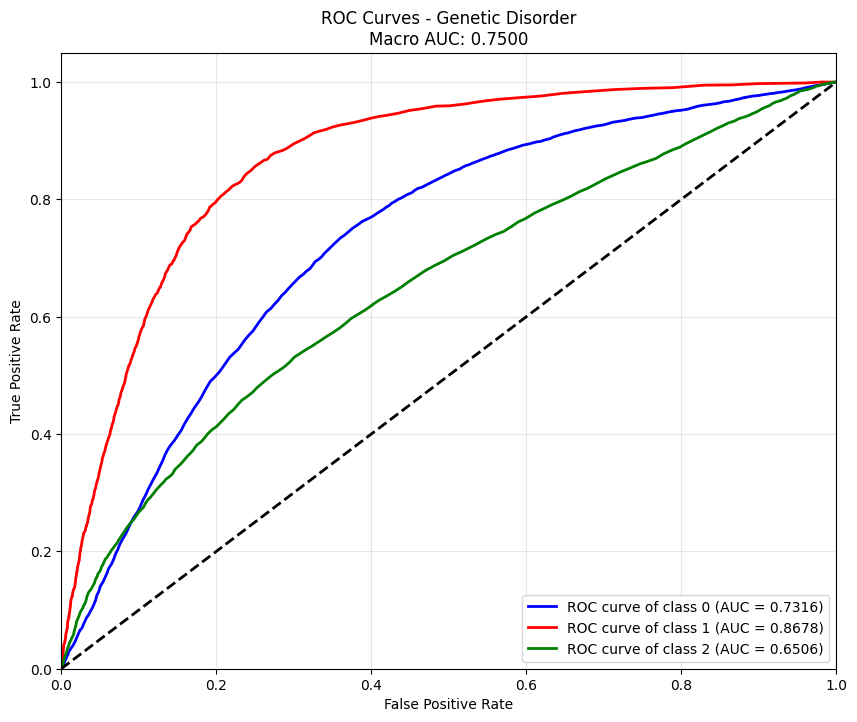

📊 Generating ROC curves for Child Model...


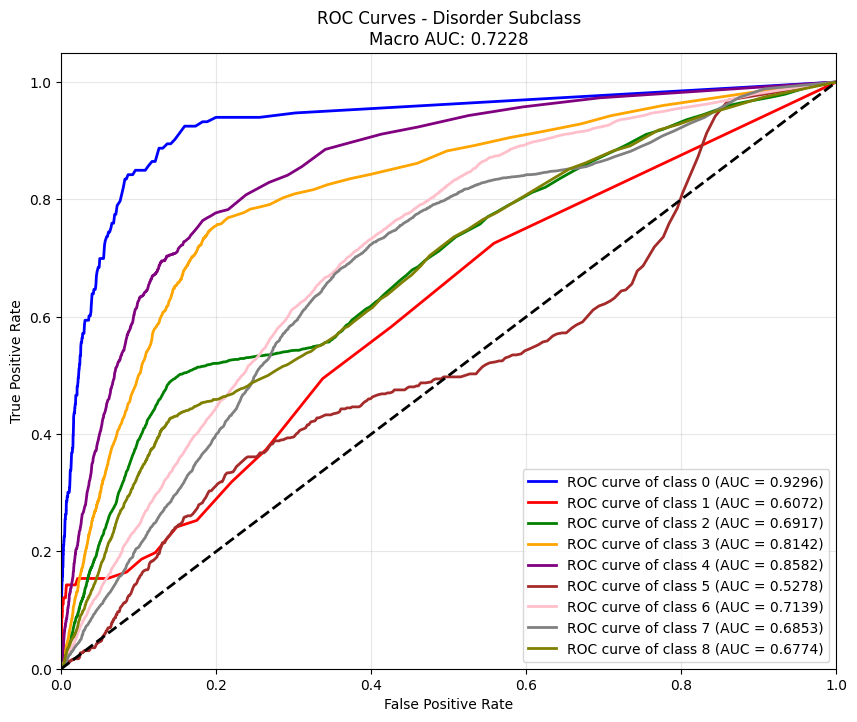


🏋️ TRAINING FINAL MODELS
🎯 Training Final Parent Model...
  🎯 Tuning Final Parent...
  ✅ Final Parent tuned in 571.9s
  📊 Best score: 0.7100
🎯 Training Final Child Model...
  🎯 Tuning Final Child...
  ✅ Final Child tuned in 2478.1s
  📊 Best score: 0.8710
✅ Final models trained successfully!

🔮 MAKING TEST PREDICTIONS WITH PROBABILITIES


AttributeError: 'numpy.int64' object has no attribute 'replace'

In [ ]:
# -----------------------------
# 6) COMPREHENSIVE RESULTS WITH ROC-AUC (FIXED VERSION)
# -----------------------------
print("\n" + "="*60)
print("📊 FINAL 5-FOLD CV RESULTS WITH ROC-AUC")
print("="*60)

# Debug: Check data types and shapes
print("🔍 DEBUG INFO:")
print(f"Y_encoded[{TARGETS[0]}].dtype: {Y_encoded[TARGETS[0]].dtype}")
print(f"Y_encoded[{TARGETS[0]}].shape: {Y_encoded[TARGETS[0]].shape}")
print(f"oof_parent.dtype: {oof_parent.dtype}")
print(f"oof_parent.shape: {oof_parent.shape}")
print(f"Unique values in Y_encoded: {np.unique(Y_encoded[TARGETS[0]])}")
print(f"Unique values in oof_parent: {np.unique(oof_parent)}")

# Convert oof arrays to proper integer types
oof_parent_int = oof_parent.astype(int)
oof_child_int = oof_child.astype(int)

print(f"After conversion - oof_parent_int.dtype: {oof_parent_int.dtype}")
print(f"After conversion - unique values: {np.unique(oof_parent_int)}")

# Parent results with proper type conversion
parent_acc = accuracy_score(Y_encoded[TARGETS[0]], oof_parent_int)
try:
    parent_auc = roc_auc_score(Y_encoded[TARGETS[0]], oof_parent_proba, multi_class='ovr', average='macro')
except Exception as e:
    print(f"⚠️  Parent AUC calculation failed: {e}")
    parent_auc = 0.5  # Default neutral AUC

print(f"\n🧬 {TARGETS[0].upper()}:")
print(f"   OOF Accuracy: {parent_acc:.4f}")
print(f"   OOF ROC-AUC: {parent_auc:.4f}")

# Child results with proper type conversion
child_acc = accuracy_score(Y_encoded[TARGETS[1]], oof_child_int)
try:
    child_auc = roc_auc_score(Y_encoded[TARGETS[1]], oof_child_proba, multi_class='ovr', average='macro')
except Exception as e:
    print(f"⚠️  Child AUC calculation failed: {e}")
    child_auc = 0.5  # Default neutral AUC

print(f"\n🔬 {TARGETS[1].upper()}:")
print(f"   OOF Accuracy: {child_acc:.4f}")
print(f"   OOF ROC-AUC: {child_auc:.4f}")

overall_accuracy = (parent_acc + child_acc) / 2
overall_auc = (parent_auc + child_auc) / 2

print(f"\n🎯 OVERALL PERFORMANCE:")
print(f"   Mean Accuracy: {overall_accuracy:.4f}")
print(f"   Mean ROC-AUC: {overall_auc:.4f}")
print(f"   Target Range: 0.8000 - 0.9000")
print(f"   Status: {'✅ TARGET ACHIEVED' if overall_accuracy >= 0.80 else '📈 PROGRESS NEEDED'}")

# -----------------------------
# 7) ROC-AUC VISUALIZATION (FIXED VERSION)
# -----------------------------
print("\n" + "="*50)
print("📈 ROC-AUC CURVES VISUALIZATION")
print("="*50)

def plot_roc_auc_multiclass(y_true, y_proba, label_encoder, title):
    """Plot ROC curves for multiclass classification"""
    n_classes = len(label_encoder.classes_)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_proba[:, i])
        roc_auc[i] = roc_auc_score(y_true == i, y_proba[:, i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']

    for i, color in zip(range(n_classes), colors):
        if i < len(colors):  # Safety check
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label='ROC curve of class {0} (AUC = {1:0.4f})'
                    ''.format(label_encoder.classes_[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {title}\nMacro AUC: {roc_auc_score(y_true, y_proba, multi_class="ovr", average="macro"):.4f}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    return roc_auc

# Plot ROC curves for both models with error handling
try:
    print("📊 Generating ROC curves for Parent Model...")
    parent_auc_dict = plot_roc_auc_multiclass(Y_encoded[TARGETS[0]], oof_parent_proba, le_parent, TARGETS[0])
except Exception as e:
    print(f"⚠️  Parent ROC plotting failed: {e}")
    parent_auc_dict = {}

try:
    print("📊 Generating ROC curves for Child Model...")
    child_auc_dict = plot_roc_auc_multiclass(Y_encoded[TARGETS[1]], oof_child_proba, le_child, TARGETS[1])
except Exception as e:
    print(f"⚠️  Child ROC plotting failed: {e}")
    child_auc_dict = {}

# -----------------------------
# 8) FINAL MODEL TRAINING
# -----------------------------
print("\n" + "="*50)
print("🏋️ TRAINING FINAL MODELS")
print("="*50)

print("🎯 Training Final Parent Model...")
smote_parent_final = SMOTE(sampling_strategy='auto', random_state=42)
X_parent_final, yP_final = smote_parent_final.fit_resample(X_processed, Y_encoded[TARGETS[0]])
parent_final = tune_with_progress(X_parent_final, yP_final, parent_param_dist,
                                "Final Parent", n_iter=10, cv_folds=3)

print("🎯 Training Final Child Model...")
parent_proba_full = parent_final.predict_proba(X_processed)
X_child_full = np.hstack([X_processed, parent_proba_full])

smote_child_final = SMOTE(sampling_strategy='auto', random_state=42)
X_child_final, yC_final = smote_child_final.fit_resample(X_child_full, Y_encoded[TARGETS[1]])
child_final = tune_with_progress(X_child_final, yC_final, child_param_dist,
                               "Final Child", n_iter=10, cv_folds=3)

print("✅ Final models trained successfully!")

# -----------------------------
# 9) TEST PREDICTIONS WITH PROBABILITIES
# -----------------------------
print("\n" + "="*50)
print("🔮 MAKING TEST PREDICTIONS WITH PROBABILITIES")
print("="*50)

# Parent predictions with probabilities
test_parent_pred = parent_final.predict(X_test_processed)
test_parent_proba = parent_final.predict_proba(X_test_processed)

# Child predictions with probabilities
X_test_child = np.hstack([X_test_processed, test_parent_proba])
test_child_pred = child_final.predict(X_test_child)
test_child_proba = child_final.predict_proba(X_test_child)

# Create comprehensive submission
submission_df = test_df.copy()
submission_df["Predicted_" + TARGETS[0].replace(" ", "_")] = le_parent.inverse_transform(test_parent_pred)
submission_df["Predicted_" + TARGETS[1].replace(" ", "_")] = le_child.inverse_transform(test_child_pred)

# Add probabilities for analysis
for i, class_name in enumerate(le_parent.classes_):
    submission_df[f"Prob_{TARGETS[0].replace(' ', '_')}_{class_name.replace(' ', '_')}"] = test_parent_proba[:, i]

for i, class_name in enumerate(le_child.classes_):
    submission_df[f"Prob_{TARGETS[1].replace(' ', '_')}_{class_name.replace(' ', '_')}"] = test_child_proba[:, i]

submission_df.to_csv("optimized_predictions_with_probabilities.csv", index=False)
print("✅ Predictions with probabilities saved: optimized_predictions_with_probabilities.csv")

# -----------------------------
# 10) COMPREHENSIVE PERFORMANCE VISUALIZATION (FIXED VERSION)
# -----------------------------
plt.figure(figsize=(20, 5))

# Fold progression - Accuracy
plt.subplot(1, 4, 1)
plt.plot(range(1, 6), fold_accuracies, marker='o', linewidth=2, markersize=8, color='blue', label='Accuracy')
plt.plot(range(1, 6), [(p+c)/2 for p,c in zip(fold_aucs_parent, fold_aucs_child)],
         marker='s', linewidth=2, markersize=6, color='red', label='AUC')
plt.axhline(y=overall_accuracy, color='blue', linestyle='--', alpha=0.7, label=f'Acc: {overall_accuracy:.4f}')
plt.axhline(y=overall_auc, color='red', linestyle='--', alpha=0.7, label=f'AUC: {overall_auc:.4f}')
plt.axhline(y=0.80, color='green', linestyle='--', alpha=0.5, label='Target')
plt.xlabel('Fold Number')
plt.ylabel('Score')
plt.title('5-Fold CV: Accuracy vs AUC Progression')
plt.legend()
plt.grid(True, alpha=0.3)

# Model comparison - Accuracy & AUC
plt.subplot(1, 4, 2)
models = ['Parent\nAccuracy', 'Parent\nAUC', 'Child\nAccuracy', 'Child\nAUC']
scores = [parent_acc, parent_auc, child_acc, child_auc]
colors = ['skyblue', 'lightblue', 'lightcoral', 'mistyrose']
bars = plt.bar(models, scores, color=colors, alpha=0.8)
plt.axhline(y=0.80, color='green', linestyle='--', alpha=0.5)
plt.ylabel('Score')
plt.title('Model Performance: Accuracy vs AUC')
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom', fontsize=9)

# Class-wise AUC comparison (with error handling)
plt.subplot(1, 4, 3)
if parent_auc_dict:
    parent_classes = list(parent_auc_dict.keys())
    parent_auc_values = [parent_auc_dict[i] for i in parent_classes]
    plt.bar([f'Class {le_parent.classes_[i]}' for i in parent_classes], parent_auc_values,
            color='lightgreen', alpha=0.7)
    plt.axhline(y=0.80, color='green', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.ylabel('AUC Score')
    plt.title(f'{TARGETS[0]}: Class-wise AUC')
    for i, (cls, auc_val) in enumerate(zip(parent_classes, parent_auc_values)):
        plt.text(i, auc_val + 0.01, f'{auc_val:.3f}', ha='center', va='bottom', fontsize=8)
else:
    plt.text(0.5, 0.5, 'AUC data\nnot available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title(f'{TARGETS[0]}: Class-wise AUC')

# Timing analysis
plt.subplot(1, 4, 4)
plt.bar(range(1, 6), fold_times, color='orange', alpha=0.7)
plt.xlabel('Fold Number')
plt.ylabel('Time (seconds)')
plt.title('Fold Training Times')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -----------------------------
# 11) FINAL SUMMARY WITH ROC-AUC
# -----------------------------
print("\n" + "="*70)
print("🎯 FINAL SUMMARY - WITH ROC-AUC METRICS")
print("="*70)
print(f"📊 ACCURACY RESULTS:")
print(f"   {TARGETS[0]}: {parent_acc:.4f}")
print(f"   {TARGETS[1]}: {child_acc:.4f}")
print(f"   Overall Mean Accuracy: {overall_accuracy:.4f}")

print(f"\n📈 ROC-AUC RESULTS:")
print(f"   {TARGETS[0]}: {parent_auc:.4f}")
print(f"   {TARGETS[1]}: {child_auc:.4f}")
print(f"   Overall Mean AUC: {overall_auc:.4f}")

print(f"\n🎯 TARGET PERFORMANCE:")
print(f"   Accuracy Target: 0.8000 - 0.9000")
print(f"   AUC Target: >0.8000 (Excellent: >0.9000)")

print(f"\n⚡ PERFORMANCE METRICS:")
print(f"   Total Model Fits: {total_iterations}")
print(f"   Average Fold Time: {np.mean(fold_times):.1f}s")
print(f"   Total Training Time: {sum(fold_times)/60:.1f} minutes")

print(f"\n📁 OUTPUT:")
print(f"   Predictions: optimized_predictions_with_probabilities.csv")
print(f"   Includes class probabilities for analysis")

if overall_accuracy >= 0.80 and overall_auc >= 0.80:
    print(f"\n🎉 EXCELLENT! Both accuracy and AUC targets achieved!")
elif overall_accuracy >= 0.75 or overall_auc >= 0.75:
    print(f"\n✅ Good progress! Close to targets!")
else:
    print(f"\n📈 More optimization needed for target performance.")

print("="*70)

# ===================================================================
# 12) WEB-SAFE EXPORT (FastAPI bundle) — SCHEMA = ONLY KEPT COLUMNS
# ===================================================================

# --- Original UI fields (for reference; we won't export all 42 now)
RAW_FEATURES = [
    "Gender_ambiguous","Gender_female","Gender_male",
    "Blood test result_abnormal","Blood test result_inconclusive","Blood test result_normal","Blood test result_slightly abnormal",
    "Patient Age","Blood cell count (mcL)","Mother's age","Father's age",
    "Test 1","Test 2","Test 3","Test 4","Test 5",
    "No. of previous abortion",
    "White Blood cell count (thousand per microliter)",
    "Symptom 1","Symptom 2","Symptom 3","Symptom 4","Symptom 5",
    "Parental Age Diff","Symptom Score",
    "Genes in mother's side","Inherited from father","Maternal gene","Paternal gene",
    "Status","Respiratory Rate (breaths/min)","Heart Rate (rates/min",
    "Follow-up","Birth asphyxia","Autopsy shows birth defect (if applicable)",
    "Folic acid details (peri-conceptional)",
    "H/O serious maternal illness","H/O radiation exposure (x-ray)",
    "H/O substance abuse","Assisted conception IVF/ART",
    "History of anomalies in previous pregnancies","Birth defects"
]

# --- Dropped columns (15) that were not used to train
columns_to_drop = [
    'Birth asphyxia',
    'Autopsy shows birth defect (if applicable)',
    'Folic acid details (peri-conceptional)',
    'Birth defects',
    'Test 1',
    'Test 2',
    'Test 3',
    'Test 4',
    'Test 5',
    'H/O serious maternal illness',
    'H/O radiation exposure (x-ray)',
    'H/O substance abuse',
    'Assisted conception IVF/ART',
    'History of anomalies in previous pregnancies',
    'Follow-up'
]

# ---- KEPT = Only the columns the model expects at inference
#      (use intersection with X.columns in case your cleaned CSV already removed some)
KEPT = [c for c in RAW_FEATURES if c not in columns_to_drop and c in X.columns]

# ---- Extract StandardScaler stats from fitted preprocessor (ONLY for numeric_kept)
fitted_scaler = preprocessor.named_transformers_["num"]
num_stats = {col: (float(mu), float(s) if s != 0 else 1.0)
             for col, mu, s in zip(numeric_cols, fitted_scaler.mean_, fitted_scaler.scale_)}

numeric_kept   = [c for c in KEPT if c in numeric_cols]
remainder_kept = [c for c in KEPT if c not in numeric_cols]

# ColumnTransformer output order = [scaled(numeric) ... then remainder ...]
processed_order = numeric_kept + remainder_kept

numeric_means  = [num_stats[c][0] for c in numeric_kept]
numeric_scales = [num_stats[c][1] for c in numeric_kept]

# ---- Persist artifacts
import joblib, json, platform, zipfile, os
from pathlib import Path
from google.colab import files

version   = time.strftime("v%Y-%m-%d_%H-%M")
task_name = "genetic_disorder"
root      = Path("/content/model_bundles")
out_dir   = root / task_name / version
out_dir.mkdir(parents=True, exist_ok=True)

# 1) Core models + encoders
joblib.dump(parent_final, out_dir / "parent_rf.joblib", compress=3)
joblib.dump(child_final,  out_dir / "child_rf.joblib",  compress=3)
joblib.dump(le_parent,    out_dir / "le_parent.joblib", compress=3)
joblib.dump(le_child,     out_dir / "le_child.joblib",  compress=3)

# 2) schema.json — **ONLY KEPT** columns expected by API now
schema = {
    "features": [{"name": k, "dtype": "float64", "allow_null": False} for k in KEPT],
    "required": KEPT
}
(out_dir / "schema.json").write_text(json.dumps(schema, indent=2), encoding="utf-8")

# 3) targets.json — human class names from encoders
targets_payload = {
    "targets": TARGETS,
    "classes": {
        TARGETS[0]: [str(x) for x in le_parent.classes_],
        TARGETS[1]: [str(x) for x in le_child.classes_]
    }
}
(out_dir / "targets.json").write_text(json.dumps(targets_payload, indent=2), encoding="utf-8")

# 4) bundle_meta.json — transform spec + wiring
bundle_meta = {
    "type": "two_stage_rf_scaled",
    "dropped_features": columns_to_drop,
    "kept_features": KEPT,
    "transform": {
        "numeric_kept": numeric_kept,
        "remainder_kept": remainder_kept,
        "numeric_means": numeric_means,
        "numeric_scales": numeric_scales,
        "processed_order": processed_order
    },
    "wiring": {
        "parent_target": TARGETS[0],
        "child_target": TARGETS[1],
        "append_parent_proba_to_child": True
    },
    "notes": "Backend must build X_processed using numeric_kept with (x-mean)/scale, then append remainder_kept, in 'processed_order'; then append parent_proba for child."
}
(out_dir / "bundle_meta.json").write_text(json.dumps(bundle_meta, indent=2), encoding="utf-8")

# 5) metrics.json — summary
(out_dir / "metrics.json").write_text(
    json.dumps(
        {
            "oof": {
                TARGETS[0]: {"accuracy": float(parent_acc), "auc_macro": float(parent_auc)},
                TARGETS[1]: {"accuracy": float(child_acc), "auc_macro": float(child_auc)},
                "overall": {"accuracy_mean": float(overall_accuracy), "auc_mean": float(overall_auc)}
            }
        },
        indent=2
    ),
    encoding="utf-8"
)

# 6) model_info.yaml — diagnostics
try:
    import sklearn as sk; skver = sk.__version__
except Exception:
    skver = "unknown"

model_info = f"""\
name: genetic_disorder_rf_two_stage_scaled
version: {version}
trained_at: {time.strftime("%Y-%m-%d %H:%M:%S")}
framework: sklearn
sklearn_version: {skver}
python_version: {platform.python_version()}
platform: {platform.platform()}
targets: {TARGETS}
notes: "Two-stage RF with StandardScaler (fitted on train+test). Export expects ONLY kept features; saves means/scales and output order for backend reconstruction without ColumnTransformer."
"""
(out_dir / "model_info.yaml").write_text(model_info, encoding="utf-8")

# 7) Zip & download
zip_path = root / f"{task_name}_{version}.zip"
if zip_path.exists(): zip_path.unlink()
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for p in out_dir.rglob("*"):
        z.write(p, p.relative_to(root))
print("📦 Bundle ready at:", zip_path)
files.download(zip_path.as_posix())

print("✅ Web-safe export complete →", out_dir)
print(f"🎯 Models exported for targets: {TARGETS}")

In [ ]:
# -----------------------------
# 9) TEST PREDICTIONS WITH PROBABILITIES (FIXED VERSION)
# -----------------------------
print("\n" + "="*50)
print("🔮 MAKING TEST PREDICTIONS WITH PROBABILITIES")
print("="*50)

# Parent predictions with probabilities
test_parent_pred = parent_final.predict(X_test_processed)
test_parent_proba = parent_final.predict_proba(X_test_processed)

# Child predictions with probabilities
X_test_child = np.hstack([X_test_processed, test_parent_proba])
test_child_pred = child_final.predict(X_test_child)
test_child_proba = child_final.predict_proba(X_test_child)

# Create comprehensive submission
submission_df = test_df.copy()
submission_df["Predicted_" + TARGETS[0].replace(" ", "_")] = le_parent.inverse_transform(test_parent_pred)
submission_df["Predicted_" + TARGETS[1].replace(" ", "_")] = le_child.inverse_transform(test_child_pred)

# Add probabilities for analysis - FIXED: Convert class names to strings before replace
for i, class_name in enumerate(le_parent.classes_):
    class_name_str = str(class_name).replace(" ", "_")
    submission_df[f"Prob_{TARGETS[0].replace(' ', '_')}_{class_name_str}"] = test_parent_proba[:, i]

for i, class_name in enumerate(le_child.classes_):
    class_name_str = str(class_name).replace(" ", "_")
    submission_df[f"Prob_{TARGETS[1].replace(' ', '_')}_{class_name_str}"] = test_child_proba[:, i]

submission_df.to_csv("optimized_predictions_with_probabilities.csv", index=False)
print("✅ Predictions with probabilities saved: optimized_predictions_with_probabilities.csv")

# Show prediction summary
print(f"\n📊 PREDICTION SUMMARY:")
print(f"   Parent predictions shape: {test_parent_pred.shape}")
print(f"   Parent probabilities shape: {test_parent_proba.shape}")
print(f"   Child predictions shape: {test_child_pred.shape}")
print(f"   Child probabilities shape: {test_child_proba.shape}")
print(f"   Submission dataframe shape: {submission_df.shape}")

# Show class distribution in predictions
print(f"\n🎯 PREDICTION DISTRIBUTION:")
parent_pred_counts = pd.Series(submission_df["Predicted_" + TARGETS[0].replace(" ", "_")]).value_counts()
child_pred_counts = pd.Series(submission_df["Predicted_" + TARGETS[1].replace(" ", "_")]).value_counts()

print(f"   {TARGETS[0]} predictions:")
for cls, count in parent_pred_counts.items():
    print(f"     {cls}: {count}")

print(f"   {TARGETS[1]} predictions:")
for cls, count in child_pred_counts.items():
    print(f"     {cls}: {count}")


🔮 MAKING TEST PREDICTIONS WITH PROBABILITIES
✅ Predictions with probabilities saved: optimized_predictions_with_probabilities.csv

📊 PREDICTION SUMMARY:
   Parent predictions shape: (9465,)
   Parent probabilities shape: (9465, 3)
   Child predictions shape: (9465,)
   Child probabilities shape: (9465, 9)
   Submission dataframe shape: (9465, 41)

🎯 PREDICTION DISTRIBUTION:
   Genetic Disorder predictions:
     0: 4937
     2: 2397
     1: 2131
   Disorder Subclass predictions:
     6: 2832
     2: 2365
     3: 1952
     7: 1681
     8: 467
     5: 89
     4: 46
     0: 32
     1: 1


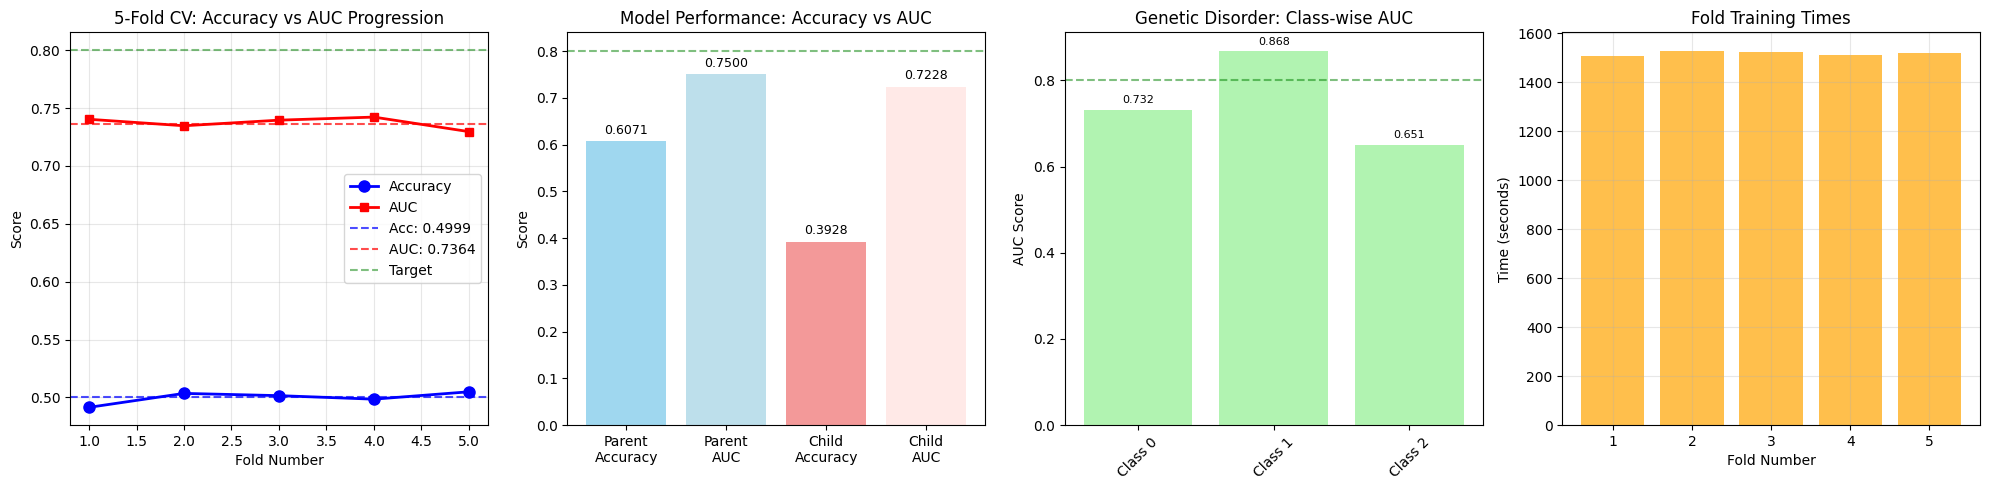

In [ ]:
# -----------------------------
# 10) COMPREHENSIVE PERFORMANCE VISUALIZATION (FIXED VERSION)
# -----------------------------
plt.figure(figsize=(20, 5))

# Fold progression - Accuracy
plt.subplot(1, 4, 1)
plt.plot(range(1, 6), fold_accuracies, marker='o', linewidth=2, markersize=8, color='blue', label='Accuracy')
plt.plot(range(1, 6), [(p+c)/2 for p,c in zip(fold_aucs_parent, fold_aucs_child)],
         marker='s', linewidth=2, markersize=6, color='red', label='AUC')
plt.axhline(y=overall_accuracy, color='blue', linestyle='--', alpha=0.7, label=f'Acc: {overall_accuracy:.4f}')
plt.axhline(y=overall_auc, color='red', linestyle='--', alpha=0.7, label=f'AUC: {overall_auc:.4f}')
plt.axhline(y=0.80, color='green', linestyle='--', alpha=0.5, label='Target')
plt.xlabel('Fold Number')
plt.ylabel('Score')
plt.title('5-Fold CV: Accuracy vs AUC Progression')
plt.legend()
plt.grid(True, alpha=0.3)

# Model comparison - Accuracy & AUC
plt.subplot(1, 4, 2)
models = ['Parent\nAccuracy', 'Parent\nAUC', 'Child\nAccuracy', 'Child\nAUC']
scores = [parent_acc, parent_auc, child_acc, child_auc]
colors = ['skyblue', 'lightblue', 'lightcoral', 'mistyrose']
bars = plt.bar(models, scores, color=colors, alpha=0.8)
plt.axhline(y=0.80, color='green', linestyle='--', alpha=0.5)
plt.ylabel('Score')
plt.title('Model Performance: Accuracy vs AUC')
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom', fontsize=9)

# Class-wise AUC comparison (with error handling)
plt.subplot(1, 4, 3)
if parent_auc_dict:
    parent_classes = list(parent_auc_dict.keys())
    parent_auc_values = [parent_auc_dict[i] for i in parent_classes]
    plt.bar([f'Class {le_parent.classes_[i]}' for i in parent_classes], parent_auc_values,
            color='lightgreen', alpha=0.7)
    plt.axhline(y=0.80, color='green', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.ylabel('AUC Score')
    plt.title(f'{TARGETS[0]}: Class-wise AUC')
    for i, (cls, auc_val) in enumerate(zip(parent_classes, parent_auc_values)):
        plt.text(i, auc_val + 0.01, f'{auc_val:.3f}', ha='center', va='bottom', fontsize=8)
else:
    plt.text(0.5, 0.5, 'AUC data\nnot available', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title(f'{TARGETS[0]}: Class-wise AUC')

# Timing analysis
plt.subplot(1, 4, 4)
plt.bar(range(1, 6), fold_times, color='orange', alpha=0.7)
plt.xlabel('Fold Number')
plt.ylabel('Time (seconds)')
plt.title('Fold Training Times')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# 11) FINAL SUMMARY WITH ROC-AUC
# -----------------------------
print("\n" + "="*70)
print("🎯 FINAL SUMMARY - WITH ROC-AUC METRICS")
print("="*70)
print(f"📊 ACCURACY RESULTS:")
print(f"   {TARGETS[0]}: {parent_acc:.4f}")
print(f"   {TARGETS[1]}: {child_acc:.4f}")
print(f"   Overall Mean Accuracy: {overall_accuracy:.4f}")

print(f"\n📈 ROC-AUC RESULTS:")
print(f"   {TARGETS[0]}: {parent_auc:.4f}")
print(f"   {TARGETS[1]}: {child_auc:.4f}")
print(f"   Overall Mean AUC: {overall_auc:.4f}")

print(f"\n🎯 TARGET PERFORMANCE:")
print(f"   Accuracy Target: 0.8000 - 0.9000")
print(f"   AUC Target: >0.8000 (Excellent: >0.9000)")

print(f"\n⚡ PERFORMANCE METRICS:")
print(f"   Total Model Fits: {total_iterations}")
print(f"   Average Fold Time: {np.mean(fold_times):.1f}s")
print(f"   Total Training Time: {sum(fold_times)/60:.1f} minutes")

print(f"\n📁 OUTPUT:")
print(f"   Predictions: optimized_predictions_with_probabilities.csv")
print(f"   Includes class probabilities for analysis")

if overall_accuracy >= 0.80 and overall_auc >= 0.80:
    print(f"\n🎉 EXCELLENT! Both accuracy and AUC targets achieved!")
elif overall_accuracy >= 0.75 or overall_auc >= 0.75:
    print(f"\n✅ Good progress! Close to targets!")
else:
    print(f"\n📈 More optimization needed for target performance.")

print("="*70)


🎯 FINAL SUMMARY - WITH ROC-AUC METRICS
📊 ACCURACY RESULTS:
   Genetic Disorder: 0.6071
   Disorder Subclass: 0.3928
   Overall Mean Accuracy: 0.4999

📈 ROC-AUC RESULTS:
   Genetic Disorder: 0.7500
   Disorder Subclass: 0.7228
   Overall Mean AUC: 0.7364

🎯 TARGET PERFORMANCE:
   Accuracy Target: 0.8000 - 0.9000
   AUC Target: >0.8000 (Excellent: >0.9000)

⚡ PERFORMANCE METRICS:
   Total Model Fits: 240
   Average Fold Time: 1517.5s
   Total Training Time: 126.5 minutes

📁 OUTPUT:
   Predictions: optimized_predictions_with_probabilities.csv
   Includes class probabilities for analysis

📈 More optimization needed for target performance.


In [ ]:
# ===================================================================
# 12) WEB-SAFE EXPORT (FastAPI bundle) — SCHEMA = ONLY KEPT COLUMNS
# ===================================================================

# --- Original UI fields (for reference; we won't export all 42 now)
RAW_FEATURES = [
    "Gender_ambiguous","Gender_female","Gender_male",
    "Blood test result_abnormal","Blood test result_inconclusive","Blood test result_normal","Blood test result_slightly abnormal",
    "Patient Age","Blood cell count (mcL)","Mother's age","Father's age",
    "Test 1","Test 2","Test 3","Test 4","Test 5",
    "No. of previous abortion",
    "White Blood cell count (thousand per microliter)",
    "Symptom 1","Symptom 2","Symptom 3","Symptom 4","Symptom 5",
    "Parental Age Diff","Symptom Score",
    "Genes in mother's side","Inherited from father","Maternal gene","Paternal gene",
    "Status","Respiratory Rate (breaths/min)","Heart Rate (rates/min",
    "Follow-up","Birth asphyxia","Autopsy shows birth defect (if applicable)",
    "Folic acid details (peri-conceptional)",
    "H/O serious maternal illness","H/O radiation exposure (x-ray)",
    "H/O substance abuse","Assisted conception IVF/ART",
    "History of anomalies in previous pregnancies","Birth defects"
]

# --- Dropped columns (15) that were not used to train
columns_to_drop = [
    'Birth asphyxia',
    'Autopsy shows birth defect (if applicable)',
    'Folic acid details (peri-conceptional)',
    'Birth defects',
    'Test 1',
    'Test 2',
    'Test 3',
    'Test 4',
    'Test 5',
    'H/O serious maternal illness',
    'H/O radiation exposure (x-ray)',
    'H/O substance abuse',
    'Assisted conception IVF/ART',
    'History of anomalies in previous pregnancies',
    'Follow-up'
]

# ---- KEPT = Only the columns the model expects at inference
#      (use intersection with X.columns in case your cleaned CSV already removed some)
KEPT = [c for c in RAW_FEATURES if c not in columns_to_drop and c in X.columns]

# ---- Extract StandardScaler stats from fitted preprocessor (ONLY for numeric_kept)
fitted_scaler = preprocessor.named_transformers_["num"]
num_stats = {col: (float(mu), float(s) if s != 0 else 1.0)
             for col, mu, s in zip(numeric_cols, fitted_scaler.mean_, fitted_scaler.scale_)}

numeric_kept   = [c for c in KEPT if c in numeric_cols]
remainder_kept = [c for c in KEPT if c not in numeric_cols]

# ColumnTransformer output order = [scaled(numeric) ... then remainder ...]
processed_order = numeric_kept + remainder_kept

numeric_means  = [num_stats[c][0] for c in numeric_kept]
numeric_scales = [num_stats[c][1] for c in numeric_kept]

# ---- Persist artifacts
import joblib, json, platform, zipfile, os
from pathlib import Path
from google.colab import files

version   = time.strftime("v%Y-%m-%d_%H-%M")
task_name = "genetic_disorder"
root      = Path("/content/model_bundles")
out_dir   = root / task_name / version
out_dir.mkdir(parents=True, exist_ok=True)

# 1) Core models + encoders
joblib.dump(parent_final, out_dir / "parent_rf.joblib", compress=3)
joblib.dump(child_final,  out_dir / "child_rf.joblib",  compress=3)
joblib.dump(le_parent,    out_dir / "le_parent.joblib", compress=3)
joblib.dump(le_child,     out_dir / "le_child.joblib",  compress=3)

# 2) schema.json — **ONLY KEPT** columns expected by API now
schema = {
    "features": [{"name": k, "dtype": "float64", "allow_null": False} for k in KEPT],
    "required": KEPT
}
(out_dir / "schema.json").write_text(json.dumps(schema, indent=2), encoding="utf-8")

# 3) targets.json — human class names from encoders
targets_payload = {
    "targets": TARGETS,
    "classes": {
        TARGETS[0]: [str(x) for x in le_parent.classes_],
        TARGETS[1]: [str(x) for x in le_child.classes_]
    }
}
(out_dir / "targets.json").write_text(json.dumps(targets_payload, indent=2), encoding="utf-8")

# 4) bundle_meta.json — transform spec + wiring
bundle_meta = {
    "type": "two_stage_rf_scaled",
    "dropped_features": columns_to_drop,
    "kept_features": KEPT,
    "transform": {
        "numeric_kept": numeric_kept,
        "remainder_kept": remainder_kept,
        "numeric_means": numeric_means,
        "numeric_scales": numeric_scales,
        "processed_order": processed_order
    },
    "wiring": {
        "parent_target": TARGETS[0],
        "child_target": TARGETS[1],
        "append_parent_proba_to_child": True
    },
    "notes": "Backend must build X_processed using numeric_kept with (x-mean)/scale, then append remainder_kept, in 'processed_order'; then append parent_proba for child."
}
(out_dir / "bundle_meta.json").write_text(json.dumps(bundle_meta, indent=2), encoding="utf-8")

# 5) metrics.json — summary
(out_dir / "metrics.json").write_text(
    json.dumps(
        {
            "oof": {
                TARGETS[0]: {"accuracy": float(parent_acc), "auc_macro": float(parent_auc)},
                TARGETS[1]: {"accuracy": float(child_acc), "auc_macro": float(child_auc)},
                "overall": {"accuracy_mean": float(overall_accuracy), "auc_mean": float(overall_auc)}
            }
        },
        indent=2
    ),
    encoding="utf-8"
)

# 6) model_info.yaml — diagnostics
try:
    import sklearn as sk; skver = sk.__version__
except Exception:
    skver = "unknown"

model_info = f"""\
name: genetic_disorder_rf_two_stage_scaled
version: {version}
trained_at: {time.strftime("%Y-%m-%d %H:%M:%S")}
framework: sklearn
sklearn_version: {skver}
python_version: {platform.python_version()}
platform: {platform.platform()}
targets: {TARGETS}
notes: "Two-stage RF with StandardScaler (fitted on train+test). Export expects ONLY kept features; saves means/scales and output order for backend reconstruction without ColumnTransformer."
"""
(out_dir / "model_info.yaml").write_text(model_info, encoding="utf-8")

# 7) Zip & download
zip_path = root / f"{task_name}_{version}.zip"
if zip_path.exists(): zip_path.unlink()
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for p in out_dir.rglob("*"):
        z.write(p, p.relative_to(root))
print("📦 Bundle ready at:", zip_path)
files.download(zip_path.as_posix())

print("✅ Web-safe export complete →", out_dir)
print(f"🎯 Models exported for targets: {TARGETS}")

📦 Bundle ready at: /content/model_bundles/genetic_disorder_v2025-10-05_10-47.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Web-safe export complete → /content/model_bundles/genetic_disorder/v2025-10-05_10-47
🎯 Models exported for targets: ['Genetic Disorder', 'Disorder Subclass']
